In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, lognorm, multivariate_normal as multinorm
import pandas as pd
from scipy.optimize import minimize

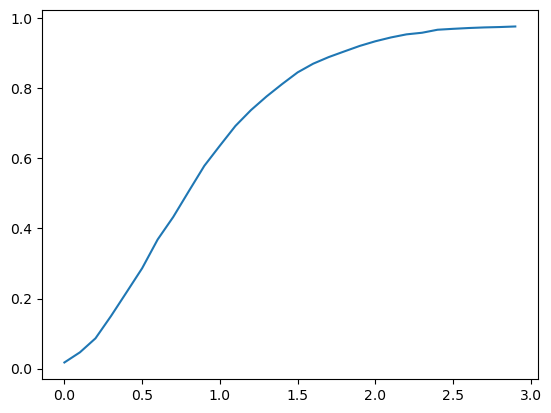

In [2]:
# Prob12.9
def gen_tc(ntrial, T):
    return np.random.choice(T, ntrial)
def gen_s(tc, T, spre, spost):
    s = np.tile(np.arange(T), (len(tc), 1))
    s = np.array(s >= tc.reshape(-1, 1), dtype = np.int8)
    return s * spre + (1-s) * spost
def gen_x(s, sigma):
    return np.random.normal(s, sigma)
def gen(spre, spost, ntrial = 10000, T = 50, sigma = 1):
    tc = gen_tc(ntrial, T)
    s = gen_s(tc, T, spre, spost)
    x = gen_x(s, sigma)
    return x, tc

def inference(x, tc):
    ans = x.cumsum(1).argmax(1) + 1
    return (ans == tc).mean()

mus = np.arange(0, 3, 0.1)
rec = [inference(*gen(-mu, mu, 10000, 50)) for mu in mus]
plt.plot(mus, rec)


In [3]:
def binary(n, x):
    k = bin(n)[2:]
    k = '0' * (x.shape[1] - len(k)) + k
    k = np.array([int(i) for i in k])
    return k, k.sum()
def k2s(k):
    return np.cumprod(1 - k * 2, 1) if len(k.shape) > 1 else np.cumprod(1 - k * 2)    
def gen_all_possible(x): 
    possibles = np.stack([k2s(binary(n, x)[0]) for n in range(2**(x.shape[1]))])
    nchange = np.array([binary(n, x)[1] for n in range(2**x.shape[1])])
    return possibles, nchange
def cal_posterior(x, sigma = 1, epi = 0.3):
    p, n = gen_all_possible(x)
    lik = norm.logpdf(x[:, np.newaxis, :], p, sigma).sum(2)
    prior = n * np.log(epi) + (len(x) -n) * np.log(1-epi)
    pz = np.exp(lik + prior)
    return pz/pz.sum()
x = np.array([[-0.25, -1.66, -0.34, -0.41, -0.55, -1.88, -2.63, -0.79, 1.54, 0.85, 2.12, 1.22, -0.85, -0.61, -1.14]])
# x = np.ones((3, 2))
ps = cal_posterior(x).flatten()

# norm.logpdf(x[:, np.newaxis, :], gen_all_possible(x)[0], 1).shape


In [59]:
idx = np.where(ps > 0.05)
[binary(n, x) for n in idx[0]], ps[idx[0]]

([(array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]), 3),
  (array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]), 3)],
 array([0.14355366, 0.23667997]))

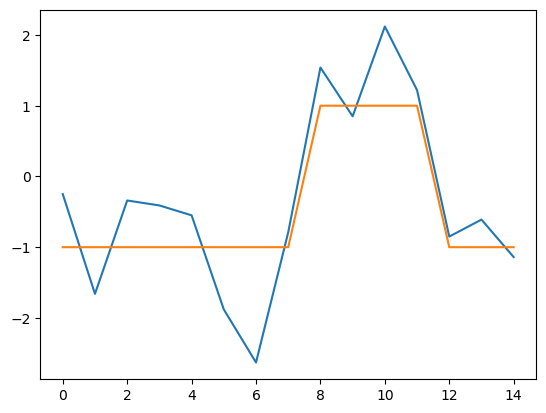

In [6]:
plt.plot(x)
plt.plot(k2s(binary(ps.argmax(), x)[0]))

In [16]:
# prob12.12
def gen_trail(N = 1000, T = 10, epi = 0.3, sigma = 1):
    k = np.random.binomial(1, epi, (N, T))
    s = k2s(k)
    x = np.random.normal(s, sigma)
    return x, k
x, k = gen_trail()
# cal_posterior(x[0])
def compare(N = 1000, T = 10, epi = 0.3, sigma = 1):
    x, k = gen_trail(N, T, epi, sigma)
    pss = cal_posterior(x)
    pred = np.stack([binary(n, x)[0] for n in pss.argmax(1)])
    count = np.array([binary(n, x)[1] for n in pss.argmax(1)])
    return (pred == k).mean(), (k.sum(1) == count).mean()


In [22]:
sigma_range = np.arange(0.1, 2, 0.1)
record = [compare(sigma = sigma) for sigma in sigma_range]

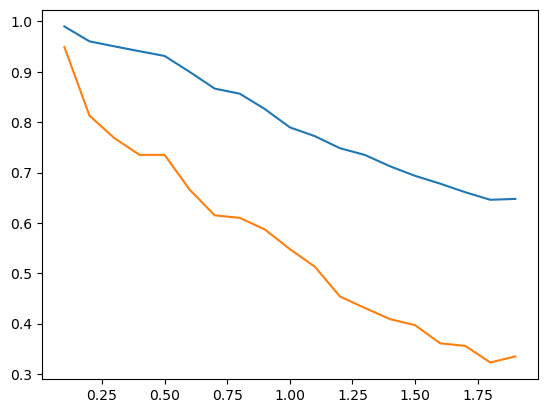

In [26]:
plt.plot(sigma_range, [rec[0] for rec in record])
plt.plot(sigma_range, [rec[1] for rec in record])
